##Setup

You will need to make a copy of this notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.

In [1]:
#@title test virtual display

#@markdown If you see a video of a four-legged ant fumbling about, setup is complete!

import gym
from cs285.infrastructure.colab_utils import (
    wrap_env,
    show_video
)

env = wrap_env(gym.make("Ant-v4", render_mode='rgb_array'))

observation = env.reset()
for i in range(100):
    env.render()
    obs, rew, term, _ = env.step(env.action_space.sample() ) 
    if term:
      break;
            
env.close()
print('Loading video...')
show_video()

C:\Users\scien\anaconda3\envs\cs285\lib\site-packages\gym\core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
C:\Users\scien\anaconda3\envs\cs285\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
C:\Users\sci

Loading video...


## Editing Code

To edit code, click the folder icon on the left menu. Navigate to the corresponding file (`cs285_f2022/...`). Double click a file to open an editor. There is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window). We sync your edits to Google Drive so that you won't lose your work in the event of an instance timeout, but you will need to re-mount your Google Drive and re-install packages with every new instance.

## Run Behavior Cloning (Problem 1)

In [2]:
#@title imports

import os
import time
import numpy as np

from cs285.infrastructure.rl_trainer import RL_Trainer
from cs285.agents.bc_agent import BCAgent
from cs285.policies.loaded_gaussian_policy import LoadedGaussianPolicy
from cs285.infrastructure.utils import MJ_ENV_KWARGS, MJ_ENV_NAMES

%load_ext autoreload
%autoreload 2

C:\Users\scien\anaconda3\envs\cs285\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\scien\anaconda3\envs\cs285\lib\site-packages\IPython\extensions\autoreload.py:121: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [42]:
#@title runtime arguments

class Args:

  def __getitem__(self, key):
    return getattr(self, key)

  def __setitem__(self, key, val):
    setattr(self, key, val)

  #@markdown expert data
  expert_policy_file = '../policies/experts/Hopper.pkl' #@param
  expert_data = '../expert_data/expert_data_Hopper-v4.pkl' #@param
  env_name = 'Hopper-v4' #@param ['Ant-v4', 'Walker2d-v4', 'HalfCheetah-v4', 'Hopper-v4']
  exp_name = 'bc_Hopper' #@param
  do_dagger = False #@param {type: "boolean"}
  ep_len = 1000 #@param {type: "integer"}
  save_params = False #@param {type: "boolean"}

  num_agent_train_steps_per_iter = 1000 #@param {type: "integer"})
  n_iter = 1 #@param {type: "integer"})

  #@markdown batches & buffers
  batch_size = 1000 #@param {type: "integer"})
  eval_batch_size = 5000 #@param {type: "integer"}
  train_batch_size = 100 #@param {type: "integer"}
  max_replay_buffer_size = 1000000 #@param {type: "integer"}

  #@markdown network
  n_layers = 2 #@param {type: "integer"}
  size = 256 #@param {type: "integer"}
  learning_rate = 5e-3 #@param {type: "number"}

  #@markdown logging
  video_log_freq = -1 #@param {type: "integer"}
  scalar_log_freq = 1 #@param {type: "integer"}

  #@markdown gpu & run-time settings
  no_gpu = False #@param {type: "boolean"}
  which_gpu = 0 #@param {type: "integer"}
  seed = 1 #@param {type: "integer"}

args = Args()


In [43]:
#@title define `BC_Trainer`
class BC_Trainer(object):

    def __init__(self, params):
        #######################
        ## AGENT PARAMS
        #######################

        agent_params = {
            'n_layers': params['n_layers'],
            'size': params['size'],
            'learning_rate': params['learning_rate'],
            'max_replay_buffer_size': params['max_replay_buffer_size'],
            }

        self.params = params
        self.params['agent_class'] = BCAgent ## TODO: look in here and implement this
        self.params['agent_params'] = agent_params

        self.params["env_kwargs"] = MJ_ENV_KWARGS[self.params['env_name']]

        ################
        ## RL TRAINER
        ################

        self.rl_trainer = RL_Trainer(self.params) ## TODO: look in here and implement this

        #######################
        ## LOAD EXPERT POLICY
        #######################

        print('Loading expert policy from...', self.params['expert_policy_file'])
        self.loaded_expert_policy = LoadedGaussianPolicy(self.params['expert_policy_file'])
        print('Done restoring expert policy...')

    def run_training_loop(self):

        self.rl_trainer.run_training_loop(
            n_iter=self.params['n_iter'],
            initial_expertdata=self.params['expert_data'],
            collect_policy=self.rl_trainer.agent.actor,
            eval_policy=self.rl_trainer.agent.actor,
            relabel_with_expert=self.params['do_dagger'],
            expert_policy=self.loaded_expert_policy,
        )


In [44]:
#@title create directory for logging

if args.do_dagger:
    logdir_prefix = 'q2_'  # The autograder uses the prefix `q2_`
    assert args.n_iter>1, ('DAgger needs more than 1 iteration (n_iter>1) of training, to iteratively query the expert and train (after 1st warmstarting from behavior cloning).')
else:
    logdir_prefix = 'q1_'  # The autograder uses the prefix `q1_`
    assert args.n_iter==1, ('Vanilla behavior cloning collects expert data just once (n_iter=1)')

data_path ='../../data'
if not (os.path.exists(data_path)):
    os.makedirs(data_path)
logdir = logdir_prefix + args.exp_name + '_' + args.env_name + \
         '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
logdir = os.path.join(data_path, logdir)
args['logdir'] = logdir
if not(os.path.exists(logdir)):
    os.makedirs(logdir)

In [45]:
## run training
print(args.logdir)
trainer = BC_Trainer(args)
trainer.run_training_loop()

../../data\q1_bc_Hopper_Hopper-v4_08-09-2022_13-41-23
########################
logging outputs to  ../../data\q1_bc_Hopper_Hopper-v4_08-09-2022_13-41-23
########################
Using GPU id 0
Loading expert policy from... ../policies/experts/Hopper.pkl
obs (1, 11) (1, 11)
Done restoring expert policy...


********** Iteration 0 ************

Training agent using sampled data from replay buffer...

Beginning logging procedure...

Eval_AverageReturn : 441.2849426269531
Eval_StdReturn : 7.685184478759766
Eval_MaxReturn : 457.56884765625
Eval_MinReturn : 429.09381103515625
Eval_AverageEpLen : 173.44827586206895
Train_AverageReturn : 3772.67041015625
Train_StdReturn : 1.9483642578125
Train_MaxReturn : 3774.61865234375
Train_MinReturn : 3770.721923828125
Train_AverageEpLen : 1000.0
Train_EnvstepsSoFar : 0
TimeSinceStart : 7.965923309326172
Training Loss : -327.059326171875
Initial_DataCollection_AverageReturn : 3772.67041015625
Done logging...




In [46]:
#@markdown You can visualize your runs with tensorboard from within the notebook

%load_ext tensorboard
%tensorboard --logdir ../../data

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17364), started 0:18:42 ago. (Use '!kill 17364' to kill it.)

## Running DAgger (Problem 2)
Modify the settings above:
1. check the `do_dagger` box
2. set `n_iters` to `10`
3. set `exp_name` to `dagger_ant`
and then rerun the code.

do_dagger= False, n_iters = 1, exp_name = bc_ant

Text(0.5, 0, 'Size of Hidden Layer')

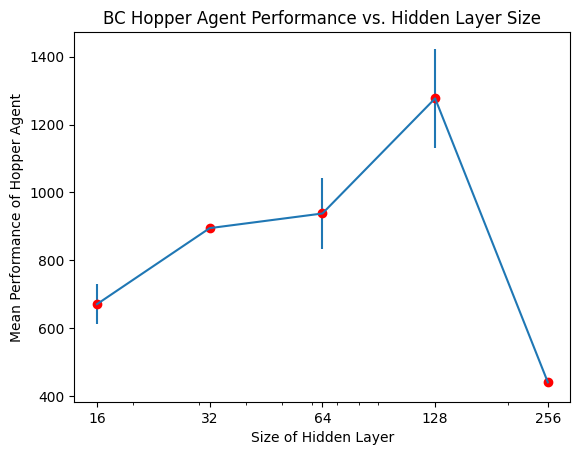

In [66]:
import matplotlib.pyplot as plt
# BC hyperparameter plot
sizes = [16, 32, 64, 128, 256]
means = [671.3, 895.1, 938.2, 1277, 441.3]
stds = [58.41, 9.793, 104.2, 145.6, 7.685]
plt.xscale('log')
plt.errorbar(sizes, means, yerr=stds)
plt.plot(sizes, means, 'ro')
plt.xticks(sizes, sizes)
plt.title("BC Hopper Agent Performance vs. Hidden Layer Size")
plt.ylabel("Mean Performance of Hopper Agent")
plt.xlabel("Size of Hidden Layer")

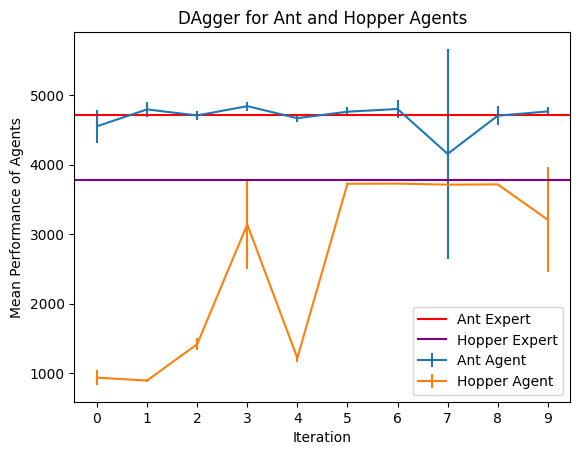

In [77]:
# Dagger plots
itr = [i for i in range(10)]
ant = [4550, 4792, 4705, 4839, 4666, 4759, 4798, 4153, 4702, 4763]
hopper = [938.2, 897, 1419, 3140, 1221, 3724, 3726, 3711, 3715, 3206]
ant_stds = [236.5, 105.1, 58.56, 66.62, 59.71, 68, 124.1, 1508, 132.5, 68.37]
hopper_stds = [104.2, 18.64, 89.3, 643.3, 59.64, 4.4, 3.473, 4.974, 2.798, 756.1]
plt.errorbar(itr, ant, yerr=ant_stds, label='Ant Agent')
plt.errorbar(itr, hopper, yerr=hopper_stds, label='Hopper Agent')
plt.axhline(y=4713.653, color='red', label='Ant Expert')
plt.axhline(y=3772.670, color='purple', label='Hopper Expert')
plt.xticks(itr, itr)
plt.title("DAgger for Ant and Hopper Agents")
plt.ylabel("Mean Performance of Agents")
plt.xlabel("Iteration")
plt.legend()